##### Copyright 2018 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Flower Classification using tf.keras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1aYrxmtr9VyWB7xKwvPACjaiZUKTt05Ox"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SiddhantAttavar/FlowerDetection/blob/master/Flowers.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Importing Packages

I started by importing required packages. **os** package is used to read files and directory structure, **numpy** is used to convert python list to numpy array and to perform required matrix operations and **matplotlib.pyplot** is used to plot the graph and display images in our training and validation data.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

### Import TensorFlow and Keras Layers

In the cell below, I imported Tensorflow and the Keras layers and models used to build the CNN. Also, I imported the `ImageDataGenerator` from Keras so that I could perform image augmentation.

In [0]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Loading

In order to build our image classifier, we can begin by downloading the flowers dataset. We first need to download the archive version of the dataset and after the download we are storing it to "/tmp/" directory.

After downloading the dataset, we need to extract its contents.

In [0]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

228818944/228813984 [==============================] - 1s 0us/step


The dataset I downloaded contains images of 5 types of flowers:

1. Rose
2. Daisy
3. Dandelion
4. Sunflowers
5. Tulips

So, I create the labels for these 5 classes: 

In [0]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

Also, the dataset downloaded has following directory structure. n
<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>diasy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
</pre>

As you can see there are no folders containing training and validation data. Therefore, I create my own training and validation set.


The code below creates a `train` and a `val` folder each containing 5 folders (one for each type of flower). It then moves the images from the original folders to these new folders such that 80% of the images go to the training set and 20% of the images go into the validation set. In the end our directory will have the following structure:


<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>diasy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
|__ <b>train</b>
    |______ <b>daisy</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>dandelion</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>roses</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>sunflowers</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>tulips</b>: [1.jpg, 2.jpg, 3.jpg ....]
 |__ <b>val</b>
    |______ <b>daisy</b>: [507.jpg, 508.jpg, 509.jpg ....]
    |______ <b>dandelion</b>: [719.jpg, 720.jpg, 721.jpg ....]
    |______ <b>roses</b>: [514.jpg, 515.jpg, 516.jpg ....]
    |______ <b>sunflowers</b>: [560.jpg, 561.jpg, 562.jpg .....]
    |______ <b>tulips</b>: [640.jpg, 641.jpg, 642.jpg ....]
</pre>

Since we don't delete the original folders, they will still be in our `flower_photos` directory, but they will be empty. The code below also prints the total number of flower images we have for each type of flower. 

In [0]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  num_train = int(round(len(images)*0.8))
  train, val = images[:num_train], images[num_train:]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


In [0]:
round(len(images)*0.8)

639

For convenience, I saved the path for the training and validation sets

In [0]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Data Augmentation

Overfitting generally occurs when we have small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, the model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In **tf.keras** we can implement this using the same **ImageDataGenerator** class we used before. We can simply pass different transformations we would want to our dataset as a form of arguments and it will take care of applying it to the dataset during our training process. 

## Experiment with Various Image Transformations

Before we begin making transformations let's define our `batch_size` and our image size. The input to our CNN are images of the same size. We therefore have to resize the images in our dataset to the same size.

### Set Batch and Image Size

In the cell below, we create a `batch_size` of 100 images and set a value to `IMG_SHAPE` such that our training data consists of images with width of 150 pixels and height of 150 pixels.

In [0]:
batch_size = 100
IMG_SHAPE = 150 

### Apply Random Horizontal Flip

In the cell below, I use ImageDataGenerator to create a transformation that rescales the images by 255 and then applies a random horizontal flip. Then I use the `.flow_from_directory` method to apply the above transformation to the images in our training set.

In [0]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE)
                                                )

Found 2935 images belonging to 5 classes.


Let's take 1 sample image from our training examples and repeat it 5 times so that the augmentation can be applied to the same image 5 times over randomly, to see the augmentation in action.

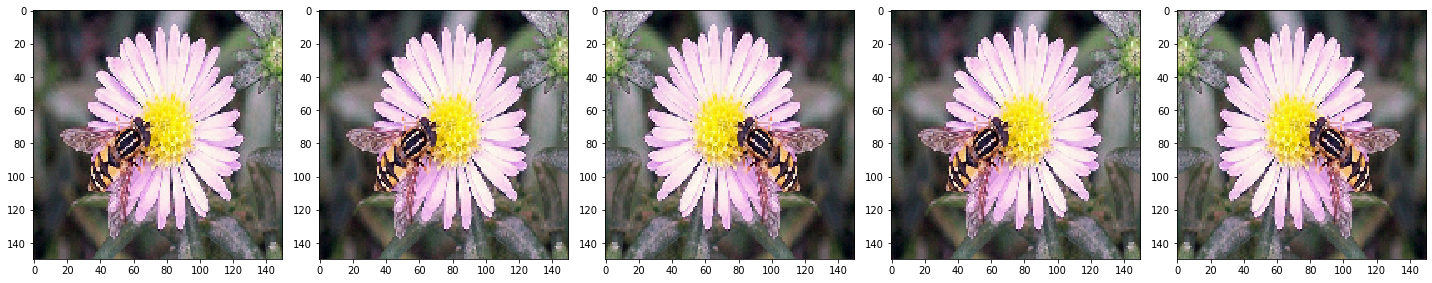

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Apply Random Rotation

In the cell below, I use ImageDataGenerator to create a transformation that rescales the images by 255 and then applies a random 45 degree rotation.

In [0]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2935 images belonging to 5 classes.


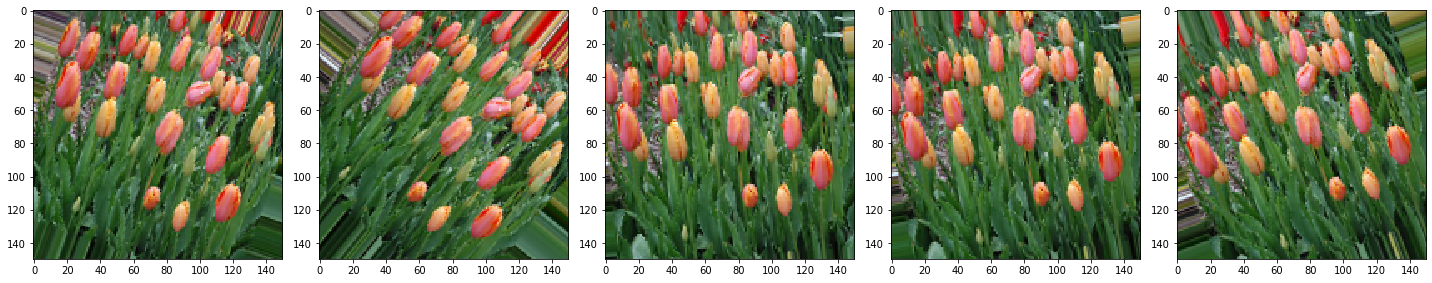

In [0]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Apply Random Zoom

In the cell below, use ImageDataGenerator to create a transformation that rescales the images by 255 and then applies a random zoom of up to 50%.

In [0]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE, IMG_SHAPE)
                                                )

Found 2935 images belonging to 5 classes.


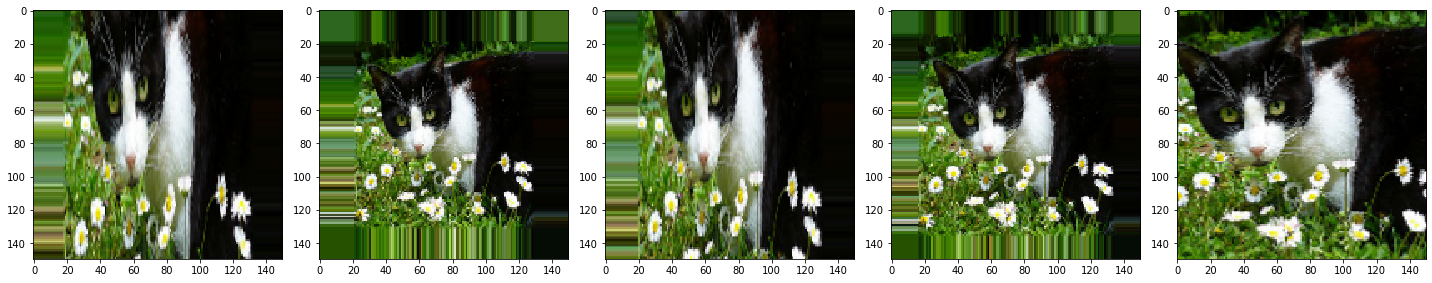

In [0]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Put It All Together

In the cell below, use ImageDataGenerator to create a transformation that rescales the images by 255 and that applies:

- random 45 degree rotation
- random zoom of up to 50%
- random horizontal flip
- width shift of 0.15
- height shift of 0.15

I set the class mode to `sparse`.

In [0]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )


train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

Found 2935 images belonging to 5 classes.


Let's visualize how a single image would look like 5 different times, when we pass these augmentations randomly to our dataset. 

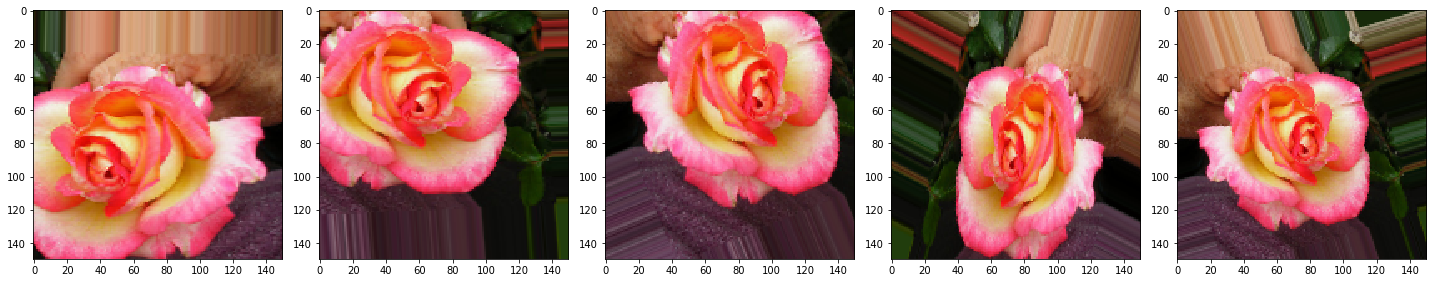

In [0]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Create a Data Generator for the Validation Set

I use ImageDataGenerator to create a transformation that only rescales the images by 255.

In [0]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 735 images belonging to 5 classes.


# Create the CNN

In the cell below, I create a convolutional neural network that consists of 3 convolution blocks. Each convolutional block contains a `Conv2D` layer followed by a max pool layer. The first convolutional block should have 16 filters, the second one should have 32 filters, and the third one should have 64 filters. All convolutional filters should be 3 x 3. All max pool layers should have a `pool_size` of `(2, 2)`.

After the 3 convolutional blocks there is a flatten layer followed by a fully connected layer with 512 units. The CNN should output class probabilities based on 5 classes which is done by the **softmax** activation function. All other layers use a **relu** activation function. I also added Dropout layers with a probability of 20%, where appropriate.

In [0]:
model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(tf.keras.layers.BatchNormalization(trainable=False))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(tf.keras.layers.BatchNormalization(trainable=False))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

#  Compile the Model

In the cell below, I compile the model using the ADAM optimizer, the sparse cross entropy function as a loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so I also pass the metrics argument.

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the Model

In the cell below, I train your model using the **fit_generator**. We have to use the `fit_generator` function because we are using the **ImageDataGenerator** class to generate batches of training and validation data for our model. I train the model for 80 epochs.

In [0]:
epochs = 80

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

Epoch 1/5
30/30 [==============================] - 25s 845ms/step - loss: 1.4651 - accuracy: 0.3819 - val_loss: 1.2188 - val_accuracy: 0.4748
Epoch 2/5
30/30 [==============================] - 23s 769ms/step - loss: 1.1645 - accuracy: 0.5087 - val_loss: 1.1081 - val_accuracy: 0.5592
Epoch 3/5
30/30 [==============================] - 23s 767ms/step - loss: 1.0766 - accuracy: 0.5761 - val_loss: 1.0855 - val_accuracy: 0.5483
Epoch 4/5
30/30 [==============================] - 23s 764ms/step - loss: 1.0035 - accuracy: 0.6136 - val_loss: 0.9658 - val_accuracy: 0.6245
Epoch 5/5
30/30 [==============================] - 23s 778ms/step - loss: 0.9488 - accuracy: 0.6283 - val_loss: 0.9640 - val_accuracy: 0.6327


# Plot Training and Validation Graphs.

In the cell below, plot the training and validation accuracy/loss graphs.

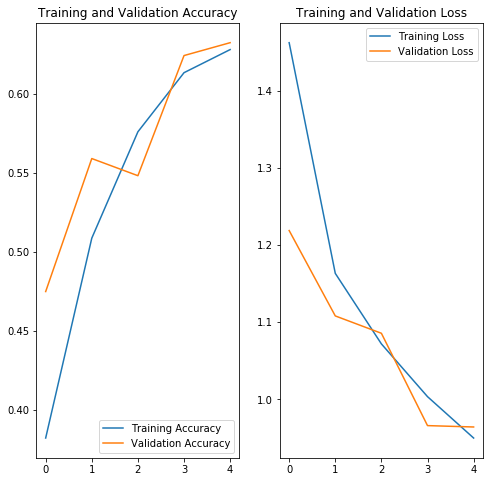

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Save the model

In the cell below, I save the model under saved_model/1

In [0]:
export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/2/assets


# Convert to .tflite

In the cell below, I set the model optimization, and convert it using the **tf.lite.TFLiteConverter** module.

In [0]:
optimization = tf.lite.Optimize.DEFAULT

In [0]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [optimization]
tflite_model = converter.convert()

ConverterError: ignored

# Creating the file and downloading it

In the cell below, I write the converted model to **detect.tflite** file and download it.

In [0]:
tflite_model_file = 'detect.tflite'

with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

In [0]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [0]:
try:
  from google.colab import files

  files.download(tflite_model_file)
  files.download('labels.txt')
except:
  pass